In [1]:
!pip install opencv-python

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import numpy as np
import pandas as pd
import cv2
import random
import os  
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show

In [4]:

conda install -c apple tensorflow-deps

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - tensorflow-deps

Current channels:

  - https://conda.anaconda.org/apple/osx-64
  - https://conda.anaconda.org/apple/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


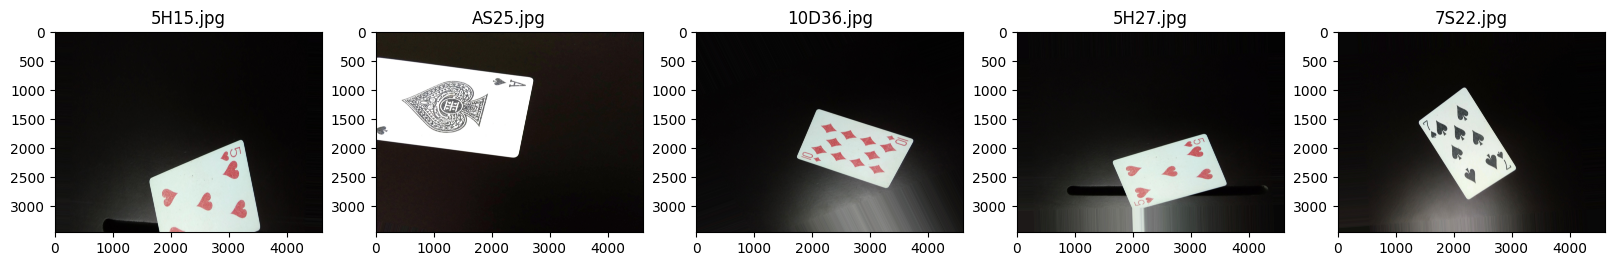

In [4]:
plt.figure(figsize=(20,20))
img_folder='/content/gdrive/MyDrive/AAI_541_Capstone/Project/RT_detection/input/Images' #
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=plt.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [5]:
IMG_WIDTH=180
IMG_HEIGHT=180

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data=[]

for i, file in tqdm(enumerate(os.listdir(img_folder))):
    label=i
    
    img = cv2.imread(img_folder+"/"+file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (180, 180))
    imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
    data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
    data_generator.fit(imgs)
    image_iterator = data_generator.flow(imgs)
    
    if(file.startswith('10')):
        file=file[:3]
    else:
        file=file[:2]
    
    for x in range(15):
        img_transformed=image_iterator.next()[0].astype('int')/255
        data.append([img_transformed, file])

shuffle(data)

np.save('C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\data.npy', data)

In [ ]:
data = np.load('C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\data.npy', allow_pickle=True)

In [ ]:
len(data)

In [ ]:
#80%
train=data[:32472]
#20%
test=data[32472:]

train_X=[]
train_y=[]
for x in train:
    train_X.append(x[0]) 
    train_y.append(x[1])
    
test_X=[]
test_y=[]
for x in test:
    test_X.append(x[0]) 
    test_y.append(x[1])


In [ ]:
train_X=np.array(train_X)
train_y=np.array(train_y)

test_X=np.array(test_X)
test_y=np.array(test_y)

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(train_y))}
target_dict

In [ ]:
target_val=  [target_dict[train_y[i]] for i in range(len(train_y))]
target_val

In [ ]:
tf.keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3])),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(52, activation='softmax')
])

In [ ]:
target_val=np.array(target_val)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
history = model.fit(train_X, target_val, batch_size=32,validation_split=.2,epochs=15)

In [ ]:
def learning_curve(hist):
  #Create a function to draw learning curves
  # This will help you to just call this function in future for drawing the learning curves
  plt.subplot(2,1,1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')

  plt.show()

learning_curve(history)

In [ ]:
predictions=model.predict(test_X)

In [ ]:
sample=test_X[:16]

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample[i].reshape(sample.shape[1], sample.shape[2]))
    # get the index of the greatest probability
    highest_prob_idx=r=predictions[i].argmax()
    # retrun the key based on the value
    value=list(target_dict.keys()) [list(target_dict.values()).index(highest_prob_idx)]
    plt.xlabel(value)
plt.show()

In [ ]:
type(predictions)

In [ ]:
print(predictions[7000])

In [ ]:
model.save('C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\card_trained_model')

NameError: name 'model' is not defined

In [ ]:
test_dict={k: v for v, k in enumerate(np.unique(test_y))}
test_target = [test_dict[test_y[i]] for i in range(len(test_y))]
test_target=np.array(test_target)

model.evaluate(test_X,test_target)

In [8]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/AAI_541_Capstone/Project/Project_files/521_Final_Project/Black_Jack/card_trained_model/card_trained_model') # 

In [ ]:
new_model.evaluate(test_X,test_target)

In [14]:
import cv2
import numpy as np
import tensorflow as tf


# Load the trained model
#new_model = tf.keras.models.load_model('card_detection_model.h5')

# Define the classes of objects that the model can detect
classes = ['Ace', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King']

# Set up the video capture from the webcam
cap = cv2.VideoCapture(0)

# Set up the video writer to save the output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

while (cap.isOpened()): # (True)
    # Capture a frame from the webcam
    ret, frame = cap.read()

    # Preprocess the image for the model
    img = cv2.resize(frame, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    # Run the model inference
    prediction = new_model.predict(img)[0]

    # Find the class with the highest probability
    class_index = np.argmax(prediction)
    class_name = classes[class_index]

    # Draw a bounding box around the detected card
    cv2.rectangle(frame, (50, 50), (200, 250), (0, 255, 0), 2)
    cv2.putText(frame, class_name, (50, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame on the screen
    cv2.imshow('frame', frame)

    # Write the frame to the output video
    out.write(frame)

    # Stop the program if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()

In [22]:
#!pip install tk
import cv2
import tkinter as Tk
from PIL import Image, ImageTk
from tkinter import *
import matplotlib
matplotlib.use('Agg')

# Create a GUI window
root = Tk()
root.title("Playing Card Detection")

# Set up a canvas for displaying the webcam feed
canvas = tk.Canvas(root, width=640, height=480)
canvas.pack()

# Load the trained model
#model = tf.keras.models.load_model('card_detection_model.h5') # ... # Your trained model here

# Define the function for processing the webcam feed and detecting playing cards
def detect_cards():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()

        # Process the image frame using the trained model to detect playing cards
        detected_cards = model.detect(frame)

        # Draw rectangles around the detected cards on the frame
        for card in detected_cards:
            cv2.rectangle(frame, (card.xmin, card.ymin), (card.xmax, card.ymax), (0, 255, 0), 2)

        # Convert the image frame to a format that can be displayed in the GUI
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)

        # Update the canvas with the new image
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.update()

        # Exit the loop if the user presses the "q" key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and destroy the GUI window
    cap.release()
    cv2.destroyAllWindows()

# Call the detect_cards function to start processing the webcam feed
detect_cards()

# Run the GUI loop
root.mainloop()

TclError: ignored

In [ ]:
import os
import random
#pull random cards to generate 52 card deck
if not os.path.exists('C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\deck'):
  os.mkdir('C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\deck')

In [ ]:
import shutil
#generate deck of cards for blackjack
numOfCards=0
while numOfCards != 52:
    img_folder='C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\archive\\Images\\Images'
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    if(file.startswith('10')):
        val_and_suit=file[:3]
    else:
        val_and_suit=file[:2]
    
    if not os.path.exists(f'C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\deck\\{val_and_suit}.jpg'):
        shutil.copy(image_path,f'C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\deck\\{val_and_suit}.jpg')
        numOfCards+=1
    else:
        continue

In [ ]:
def keep_Count(predicted_value):
    count=0
    if (predicted_value.startswith('2') or predicted_value.startswith('3') or 
    predicted_value.startswith('4') or predicted_value.startswith('5') or predicted_value.startswith('6')):
        count+=1
    elif (predicted_value.startswith('7') or predicted_value.startswith('8') or 
    predicted_value.startswith('9')):
        pass
    else:
        count-=1
    return count

In [ ]:
def hand_Value(predicted_value,userHandValue):
    hand_value=0
    if(predicted_value.startswith('2')):
        hand_value+=2
    elif(predicted_value.startswith('3')):
        hand_value+=3
    elif(predicted_value.startswith('4')):
        hand_value+=4
    elif(predicted_value.startswith('5')):
        hand_value+=5
    elif(predicted_value.startswith('6')):
        hand_value+=6
    elif(predicted_value.startswith('7')):
        hand_value+=7
    elif(predicted_value.startswith('8')):
        hand_value+=8
    elif(predicted_value.startswith('9')):
        hand_value+=9
    elif(predicted_value.startswith('A')):
        if userHandValue >= 11:
            hand_value+=1
        else:
            hand_value+=11
    else:
        hand_value+=10
    return hand_value

In [ ]:
def basic_Strategy(hand_value, dealer_card, player_cards):
    choice=''
    if not player_cards[0].startswith('A') or not player_cards[1].startswith('A'):
        if 4 <= hand_value <= 7:
            choice='hit'
        elif hand_value == 8:
            choice='hit'
        elif hand_value == 9:
            if dealer_card.startswith('2') or dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif hand_value == 10:
            if dealer_card.startswith('10') or dealer_card.startswith('J') or dealer_card.startswith('K') or dealer_card.startswith('Q') or dealer_card.startswith('A'):
                choice='hit'
            else:
                choice='double'
        elif hand_value == 11:
            choice='double'
        elif hand_value == 12:
            if dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='stand'
            else:
                choice='hit'
        elif hand_value == 13:
            if dealer_card.startswith('2') or dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='stand'
            else:
                choice='hit'
        elif hand_value == 14:
            if dealer_card.startswith('2') or dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='stand'
            else:
                choice='hit'
        elif hand_value == 15:
            if dealer_card.startswith('2') or dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='stand'
            else:
                choice='hit'
        elif hand_value == 16:
            if dealer_card.startswith('2') or dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='stand'
            else:
                choice='hit'
        else:
            choice='stand'
    else:
        if player_cards[0].startswith('2') or player_cards[1].startswith('2'):
            if dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif player_cards[0].startswith('3') or player_cards[1].startswith('3'):
            if dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif player_cards[0].startswith('4') or player_cards[1].startswith('4'):
            if dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif player_cards[0].startswith('5') or player_cards[1].startswith('5'):
            if dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif player_cards[0].startswith('6') or player_cards[1].startswith('6'):
            if dealer_card.startswith('2') or dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif player_cards[0].startswith('7') or player_cards[1].startswith('7'):
            if dealer_card.startswith('2') or dealer_card.startswith('7') or dealer_card.startswith('8'):
                choice='stand'
            elif dealer_card.startswith('3') or dealer_card.startswith('4') or dealer_card.startswith('5') or dealer_card.startswith('6'):
                choice='double'
            else:
                choice='hit'
        elif player_cards[0].startswith('8') or player_cards[1].startswith('8'):
            if dealer_card.startswith('6'):
                choice='double'
            else:
                choice='stand'
        else:
            choice='stand'
        
    return choice

In [ ]:
def image_transformation(deck_folder, file):
    image = cv2.imread(deck_folder+"/"+file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(image, (180, 180))
    imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
    data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
    data_generator.fit(imgs)
    image_iterator = data_generator.flow(imgs)
    img_transformed=image_iterator.next()[0].astype('int')/255
    img_transformed = img_transformed.reshape((1, img.shape[0], img.shape[1], 1))
    return img_transformed

In [ ]:
def predict_image(img_transformed,target_dict):
    prediction = new_model.predict(img_transformed)
    highest_prob_idx=r=prediction.argmax()
    # retrun the key based on the value
    value=list(target_dict.keys()) [list(target_dict.values()).index(highest_prob_idx)]
    return value

In [ ]:
def reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards):
    player_hand_value=0
    dealer_hand_value=0
    num_of_cards=0
    player_hand.clear()
    dealer_hand.clear()
    return player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards

In [ ]:
def get_card(deck_folder,cards_in_use):
    file = random.choice(os.listdir(deck_folder))
                    
    if file not in cards_in_use:
        cards_in_use.append(file)
        img_transformed = image_transformation(deck_folder, file)
        value = predict_image(img_transformed,target_dict)
    else:
        value = None 
        
    return value

In [ ]:
def bet_amount(count,bet_unit):
    if count <= 1:
        return bet_unit
    else:
        return bet_unit*count

In [ ]:
import math
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def Black_Jack(target_dict):
    # pick random point in deck between 60%-95% that 
    # when reached then the deck is shuffled again (simulates a casino).
    shuffle_limit = math.floor(52*random.uniform(.6, .95))
    cards_in_play=0
    player_hand=[]
    dealer_hand=[]
    cards_in_use = []
    count=0
    player_hand_value = 0
    dealer_hand_value = 0
    bank_roll = 5000.0
    bet_unit = 50.0
    num_of_units = bank_roll/bet_unit
    
    while cards_in_play < shuffle_limit or bank_roll <= 0:
        deck_folder='C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\deck'
        num_of_cards=0
        bank_roll_float = "{:.2f}".format(bank_roll)
        print('\n------------------------------------------------------------------')
        print(f"You currently have ${bank_roll_float}")
        amount = bet_amount(count,bet_unit)
        bet_amount_float = "{:.2f}".format(amount)
        print(f"Based on the current count of {count} you will bet ${bet_amount_float}")
        print("\n|||||||||||||||||||||\nNew Hand\n|||||||||||||||||||||\n")
        while num_of_cards<4:
            file = random.choice(os.listdir(deck_folder))
            
            if file not in cards_in_use:
                cards_in_use.append(file)
                img_transformed = image_transformation(deck_folder, file)
                value = predict_image(img_transformed,target_dict)
                
                if num_of_cards % 2 == 0:
                    dealer_hand.append(value)
                    count+=keep_Count(value)
                else:
                    player_hand.append(value)
                    count+=keep_Count(value)
                    player_hand_value+=hand_Value(value,player_hand_value)
                cards_in_play+=1
                num_of_cards+=1
                
            else:
                continue
        dealer_hand_value+=(hand_Value(dealer_hand[0],dealer_hand_value)+hand_Value(dealer_hand[1],dealer_hand_value))
        print("Hand 1:")
        print(str(dealer_hand)+" = "+str(dealer_hand_value))  
        print(str(player_hand)+" = "+str(player_hand_value))
        print("Current Count: ",count)
        print("===============================")
        
        
        if dealer_hand_value == 21 and player_hand_value != 21:
            print("Dealer wins!")
            bank_roll-=amount
            player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards = reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards)
            continue
        elif dealer_hand_value == 21 and player_hand_value == 21:
            print("Push")
            player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards = reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards)
            continue
        else:
            choice = basic_Strategy(player_hand_value, dealer_hand[1], player_hand)  
            #player
            hand_num=1
            while not choice == 'stand':
                if choice == 'hit':
                    print("Player will hit.")
                    
                    while player_hand_value < 17:
                        value = get_card(deck_folder,cards_in_use)
                        if value is None:
                            continue
                        else:
                            count+=keep_Count(value)
                            cards_in_play+=1
                            player_hand.append(value)
                            hand_num+=1
                            player_hand_value += hand_Value(value,player_hand_value)
                            print(f"Hand {hand_num}:")
                            print(str(dealer_hand)+" = "+str(dealer_hand_value),flush=True)  
                            print(str(player_hand)+" = "+str(player_hand_value),flush=True)
                            print("Current Count: ",count)
                            print("===============================")
                            
                            choice = basic_Strategy(player_hand_value, dealer_hand[1], player_hand) 
                            if choice == 'stand':
                                break
                            else:
                                continue
                #double down
                else:
                    print("Player will double down.")
                    while True:
                        value = get_card(deck_folder,cards_in_use)
                        if value is None:
                            continue
                        else:
                            count+=keep_Count(value)
                            cards_in_play+=1
                            player_hand.append(value)
                            hand_num+=1
                            player_hand_value += hand_Value(value,player_hand_value)
                            print(f"Hand {hand_num}:",flush=True)
                            print(str(dealer_hand)+" = "+str(dealer_hand_value),flush=True)  
                            print(str(player_hand)+" = "+str(player_hand_value),flush=True)
                            print("Current Count: ",count)
                            print("===============================")
                            
                            choice='stand'
                            break

            print("Player will Stand")
            if player_hand_value > 21:
                print("Dealer Wins")
                bank_roll-=amount
                player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards = reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards)
                continue
            else:
                while dealer_hand_value < 17:
                    value = get_card(deck_folder,cards_in_use)
                    if value is None:
                        continue
                    else:
                        count+=keep_Count(value)
                        cards_in_play+=1
                        dealer_hand.append(value)
                        dealer_hand_value += hand_Value(value,dealer_hand_value)
                        hand_num+=1
                        print(f"Hand {hand_num}:")
                        print(str(dealer_hand)+" = "+str(dealer_hand_value))  
                        print(str(player_hand)+" = "+str(player_hand_value))
                        print("Current Count: ",count)
                        print("===============================")

                if player_hand_value > 21 or dealer_hand_value > player_hand_value:
                    if dealer_hand_value > 21 and player_hand_value <= 21:
                        print("Player Wins")
                        bank_roll+=amount
                    else:
                        print("Dealer wins")
                        bank_roll-=amount
                    player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards = reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards)
                    continue
                elif dealer_hand_value > 21 or dealer_hand_value < player_hand_value:
                    print("Player wins")
                    bank_roll+=amount
                    player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards = reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards)
                    continue
                else:
                    print("Push")
                    player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards = reset_values(player_hand_value,dealer_hand_value,player_hand,dealer_hand,num_of_cards)
                    continue
                    
    profit = bank_roll - 5000.0
    if profit > 0:
        profit_float = "{:.2f}".format(profit)
        print(f'\nYou have made ${profit}')
    else:
        profit*=-1
        profit_float = "{:.2f}".format(profit)
        print(f'\nYou have lost ${profit}')

C:\Users\glmor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
target_dict={'10C': 0,
 '10D': 1,
 '10H': 2,
 '10S': 3,
 '2C': 4,
 '2D': 5,
 '2H': 6,
 '2S': 7,
 '3C': 8,
 '3D': 9,
 '3H': 10,
 '3S': 11,
 '4C': 12,
 '4D': 13,
 '4H': 14,
 '4S': 15,
 '5C': 16,
 '5D': 17,
 '5H': 18,
 '5S': 19,
 '6C': 20,
 '6D': 21,
 '6H': 22,
 '6S': 23,
 '7C': 24,
 '7D': 25,
 '7H': 26,
 '7S': 27,
 '8C': 28,
 '8D': 29,
 '8H': 30,
 '8S': 31,
 '9C': 32,
 '9D': 33,
 '9H': 34,
 '9S': 35,
 'AC': 36,
 'AD': 37,
 'AH': 38,
 'AS': 39,
 'JC': 40,
 'JD': 41,
 'JH': 42,
 'JS': 43,
 'KC': 44,
 'KD': 45,
 'KH': 46,
 'KS': 47,
 'QC': 48,
 'QD': 49,
 'QH': 50,
 'QS': 51}

Black_Jack(target_dict)

In [ ]:
from PIL import Image, ImageTk
import tkinter as tk
import random
from tkinter import messagebox
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class Blackjack:
    def __init__(self, master):
        self.master = master
        self.master.title("Blackjack")
        
        # Load the pre-trained model for card identification
        self.model = self.load_pretrained_model()
        
        self.target_dict = {
            '10_of_clubs': 0,
            '10_of_diamonds': 1,
            '10_of_hearts': 2,
            '10_of_spades': 3,
            '2_of_clubs': 4,
            '2_of_diamonds': 5,
            '2_of_hearts': 6,
            '2_of_spades': 7,
            '3_of_clubs': 8,
            '3_of_diamonds': 9,
            '3_of_hearts': 10,
            '3_of_spades': 11,
            '4_of_clubs': 12,
            '4_of_diamonds': 13,
            '4_of_hearts': 14,
            '4_of_spades': 15,
            '5_of_clubs': 16,
            '5_of_diamonds': 17,
            '5_of_hearts': 18,
            '5_of_spades': 19,
            '6_of_clubs': 20,
            '6_of_diamonds': 21,
            '6_of_hearts': 22,
            '6_of_spades': 23,
            '7_of_clubs': 24,
            '7_of_diamonds': 25,
            '7_of_hearts': 26,
            '7_of_spades': 27,
            '8_of_clubs': 28,
            '8_of_diamonds': 29,
            '8_of_hearts': 30,
            '8_of_spades': 31,
            '9_of_clubs': 32,
            '9_of_diamonds': 33,
            '9_of_hearts': 34,
            '9_of_spades': 35,
            'ace_of_clubs': 36,
            'ace_of_diamonds': 37,
            'ace_of_hearts': 38,
            'ace_of_spades': 39,
            'jack_of_clubs': 40,
            'jack_of_diamonds': 41,
            'jack_of_hearts': 42,
            'jack_of_spades': 43,
            'king_of_clubs': 44,
            'king_of_diamonds': 45,
            'king_of_hearts': 46,
            'king_of_spades': 47,
            'queen_of_clubs': 48,
            'queen_of_diamonds': 49,
            'queen_of_hearts': 50,
            'queen_of_spades': 51,
        }


        # Create the main frame for the game
        self.frame = tk.Frame(self.master, width=750, height=750)
        self.frame.pack()
        
        # Initialize money and bet variables
        self.money = 1000
        self.bet = 0
        
        # Create money and bet labels
        self.money_label = tk.Label(self.frame, text=f"Money: ${self.money}")
        self.money_label.grid(row=3, column=1)
        self.bet_label = tk.Label(self.frame, text=f"Bet: ${self.bet}")
        self.bet_label.grid(row=3, column=2)
        
        # Create bet entry and button
        self.bet_entry = tk.Entry(self.frame)
        self.bet_entry.grid(row=4, column=0)
        self.bet_button = tk.Button(self.frame, text="Place Bet", command=self.place_bet)
        self.bet_button.grid(row=4, column=1)

        # Create the player's hand label
        self.player_hand_label = tk.Label(self.frame, text="Player's Hand:")
        self.player_hand_label.grid(row=0, column=0)

        # Create the dealer's hand label
        self.dealer_hand_label = tk.Label(self.frame, text="Dealer's Hand:")
        self.dealer_hand_label.grid(row=1, column=0)

        # Create the hit button
        self.hit_button = tk.Button(self.frame, text="Hit", command=self.hit)
        self.hit_button.grid(row=2, column=0)

        # Create the stand button
        self.stand_button = tk.Button(self.frame, text="Stand", command=self.stand)
        self.stand_button.grid(row=2, column=1)
        
        #for basic strategy
        self.recommendation_label = tk.Label(self.frame, text="")
        self.recommendation_label.grid(row=5, column=0)

        # Create the double down button
        self.double_down_button = tk.Button(self.frame, text="Double Down", command=self.double_down)
        self.double_down_button.grid(row=2, column=2)

        # Create the new game button
        self.new_game_button = tk.Button(self.frame, text="New Game", command=self.new_game)
        self.new_game_button.grid(row=2, column=3)

        # Initialize the deck
        suits = ['spades', 'hearts', 'diamonds', 'clubs']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'jack', 'queen', 'king', 'ace']

        cards = []

        for suit in suits:
            for rank in ranks:
                card = rank + '_of_' + suit
                cards.append(card)
        self.deck = cards
        random.shuffle(self.deck)
        
        self.reshuffle_point = random.randint(15, 30)  # Set the reshuffle point
        self.cards_dealt = 0  # Initialize the count of cards dealt
        self.reshuffled = False
        self.busted = False
        
        # Initialize the player's and dealer's hands
        self.player_hand = []
        self.dealer_hand = []
        self.player_card_labels = []
        self.dealer_card_labels = []
        
        self.card_count = 0
        self.card_count_label = tk.Label(self.frame, text=f"Card Count: {self.card_count}")
        self.card_count_label.grid(row=3, column=0)

        # Load the card images
        self.card_images = {}
        suits = ["hearts", "diamonds", "clubs", "spades"]
        for suit in suits:
            for i in range(2, 11):
                filename = f"GUI_cards/{i}_of_{suit}.png"
                image = Image.open(filename)
                resized_image = image.resize((100, 150), Image.ANTIALIAS)
                self.card_images[f"{i}_of_{suit}"] = ImageTk.PhotoImage(resized_image)
            for name in ["jack", "queen", "king", "ace"]:
                filename = f"GUI_cards/{name}_of_{suit}.png"
                image = Image.open(filename)
                resized_image = image.resize((100, 150), Image.ANTIALIAS)
                self.card_images[f"{name}_of_{suit}"] = ImageTk.PhotoImage(resized_image)

        filename = f"back.png"
        image = Image.open(filename)
        resized_image = image.resize((100, 150), Image.ANTIALIAS)
        self.card_images["back"] = ImageTk.PhotoImage(resized_image)
        
    def load_pretrained_model(self):
        # Load your pre-trained model here
        model = tf.keras.models.load_model('C:\\Users\\glmor\\OneDrive\\Desktop\\521_Final_Project\\card_trained_model')
        return model
    
    def image_transformation(self, deck_folder, file):
        image = cv2.imread(deck_folder+"/"+file, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(image, (180, 180))
        imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
        data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), 
                                            shear_range=15.0, zoom_range=[.3, .8])
        data_generator.fit(imgs)
        image_iterator = data_generator.flow(imgs)
        img_transformed=image_iterator.next()[0].astype('int')/255
        img_transformed = img_transformed.reshape((1, img.shape[0], img.shape[1], 1))
        return img_transformed
    
    def predict_image(self, img_transformed, target_dict):
        prediction = self.model.predict(img_transformed)
        highest_prob_idx=r=prediction.argmax()
        # retrun the key based on the value
        value=list(target_dict.keys()) [list(target_dict.values()).index(highest_prob_idx)]
        return value
        
    def update_card_count(self, card):
        if card.startswith('2') or card.startswith('3') or card.startswith('4') or card.startswith('5') or card.startswith('6'):
            self.card_count += 1
        elif card.startswith('10') or card.startswith('j') or card.startswith('q') or card.startswith('k') or card.startswith('a'):
            self.card_count -= 1

        self.card_count_label.config(text=f"Card Count: {self.card_count}")

    def deal(self):
        self.clear_hands()
        # Check if the deck should be reshuffled
        if self.cards_dealt >= self.reshuffle_point:
            self.reshuffled = True
            self.reshuffle_point = random.randint(15, 30)  # Set a new reshuffle point
            self.cards_dealt = 0  # Reset the count of cards dealt
            self.card_count = 0

            # Initialize the deck
            suits = ['spades', 'hearts', 'diamonds', 'clubs']
            ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'jack', 'queen', 'king', 'ace']

            cards = []

            for suit in suits:
                for rank in ranks:
                    card = rank + '_of_' + suit
                    cards.append(card)
            self.deck = cards
            random.shuffle(self.deck)

            if self.reshuffled:
                messagebox.showinfo("Reshuffle", "The deck has been reshuffled.")
                self.reshuffled = False

        # Deal two cards to the player and dealer
        for i in range(2):
            player_card = self.deck.pop()
            img_transformed = self.image_transformation('C:/Users/glmor/OneDrive/Desktop/521_Final_Project/deck', f'{player_card}.png')
            value = self.predict_image(img_transformed, self.target_dict)
            self.player_hand.append(value)
            self.cards_dealt += 1
            
            dealer_card = self.deck.pop()
            img_transformed = self.image_transformation('C:/Users/glmor/OneDrive/Desktop/521_Final_Project/deck', f'{dealer_card}.png')
            value = self.predict_image(img_transformed, self.target_dict)
            self.dealer_hand.append(value)
            self.cards_dealt += 1

        self.update_hands()
        self.update_card_count(self.player_hand[0])
        self.update_card_count(self.player_hand[1])
        self.update_card_count(self.dealer_hand[1])
        
        self.update_recommendation()

    def update_hands(self):
        # Remove old card labels
        for card_label in self.player_card_labels:
            card_label.destroy()
        for card_label in self.dealer_card_labels:
            card_label.destroy()

        # Clear the lists of card labels
        self.player_card_labels = []
        self.dealer_card_labels = []

        # Clear the hand labels
        self.player_hand_label.config(text="Player's Hand: ")
        self.dealer_hand_label.config(text="Dealer's Hand: ")

        # Add the player's cards to the hand label
        for card in self.player_hand:
            card_image = self.card_images[card]
            card_label = tk.Label(self.frame, image=card_image)
            card_label.image = card_image  # Save a reference to avoid garbage collection
            card_label.grid(row=0, column=self.player_hand.index(card) + 1, padx=5)
            self.player_card_labels.append(card_label)

        # Add the dealer's first card with the back image
        dealer_first_card_back_image = self.card_images["back"]
        dealer_first_card_label = tk.Label(self.frame, image=dealer_first_card_back_image)
        dealer_first_card_label.image = dealer_first_card_back_image  # Save a reference to avoid garbage collection
        dealer_first_card_label.grid(row=1, column=2, padx=5)
        self.dealer_card_labels.append(dealer_first_card_label)

        # Add the dealer's second card to the hand label
        dealer_second_card = self.dealer_hand[1]
        dealer_second_card_image = self.card_images[dealer_second_card]
        dealer_second_card_label = tk.Label(self.frame, image=dealer_second_card_image)
        dealer_second_card_label.image = dealer_second_card_image  # Save a reference to avoid garbage collection
        dealer_second_card_label.grid(row=1, column=1, padx=5)
        self.dealer_card_labels.append(dealer_second_card_label)
        
    def get_recommended_action(self, player_hand, dealer_up_card):
        player_value = self.get_hand_value(player_hand)
        dealer_up_card_value = self.get_hand_value([dealer_up_card])

        # Check for double down opportunities
        if len(player_hand) == 2 and self.bet <= self.money:
            if (player_value == 9 and (dealer_up_card_value in range(3, 7))) or \
                    (player_value == 10 and (dealer_up_card_value in range(2, 10))) or \
                    (player_value == 11 and (dealer_up_card_value in range(2, 11))):
                return "Double Down"

        # Basic strategy for hard totals
        if player_value >= 17:
            return "Stand"
        elif player_value >= 13 and dealer_up_card_value in range(2, 7):
            return "Stand"
        elif player_value == 12 and dealer_up_card_value in range(4, 7):
            return "Stand"
        else:
            return "Hit"
        
    def update_recommendation(self):
        recommended_action = self.get_recommended_action(self.player_hand, self.dealer_hand[1])
        self.recommendation_label.config(text=f"Recommended Action: {recommended_action}")


    def place_bet(self):
        try:
            bet_amount = int(self.bet_entry.get())
        except ValueError:
            messagebox.showerror("Invalid Bet", "Please enter a valid bet amount.")
            return
        
        if bet_amount > self.money:
            messagebox.showerror("Insufficient Funds", "You do not have enough money to place this bet.")
            return
        elif bet_amount <= 0:
            messagebox.showerror("Invalid Bet", "Please enter a bet amount greater than 0.")
            return
        
        self.bet = bet_amount
        self.money -= bet_amount
        self.bet_label.config(text=f"Bet: ${self.bet}")
        self.money_label.config(text=f"Money: ${self.money}")
        
        self.deal()

    def clear_hands(self):
        # Clear the player's and dealer's hands
        self.player_hand = []
        self.dealer_hand = []

        # Remove all card images from the hand labels
        for child in self.player_hand_label.winfo_children():
            child.destroy()
        for child in self.dealer_hand_label.winfo_children():
            child.destroy()


    def get_hand_value(self, hand):
        # Calculate the value of a hand
        value = 0
        num_aces = 0

        for card in hand:
            if card.startswith("j") or card.startswith("q") or card.startswith("k"):
                value += 10
            elif card.startswith("a"):
                num_aces += 1
                value += 11
            else:
                values = card.split('_')
                value += int(values[0])

        # If the hand contains aces and the value is over 21, change the value of an ace to 1
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        return value

    def hit(self):
        # Deal one more card to the player
        player_card = self.deck.pop()
        img_transformed = self.image_transformation('C:/Users/glmor/OneDrive/Desktop/521_Final_Project/deck', f'{player_card}.png')
        value = self.predict_image(img_transformed, self.target_dict)
        self.player_hand.append(value)
        self.cards_dealt += 1
        self.update_card_count(self.player_hand[-1])
        
        # Update the hand labels
        self.update_hands()
        self.update_recommendation()
        # Check if the player has gone over 21 (busted)
        if self.get_hand_value(self.player_hand) > 21:
            # Reveal the dealer's cards until the dealer's hand value is 17 or higher
            self.busted = True
            self.stand()
            
    def double_down(self):
        if self.bet > self.money:
            messagebox.showerror("Insufficient Funds", "You do not have enough money to double down.")
            return

        # Double the bet
        self.money -= self.bet
        self.bet *= 2
        self.bet_label.config(text=f"Bet: ${self.bet}")
        self.money_label.config(text=f"Money: ${self.money}")

        # Player hits
        self.hit()
        self.update_recommendation()
        # Player stands if not busted
        if self.get_hand_value(self.player_hand) <= 21:
            self.stand()

    def stand(self):
        # Remove the back of the dealer's first card
        self.dealer_card_labels[0].destroy()

        # Reveal the dealer's first card
        dealer_first_card = self.dealer_hand[0]
        dealer_first_card_image = self.card_images[dealer_first_card]
        dealer_first_card_label = tk.Label(self.frame, image=dealer_first_card_image)
        dealer_first_card_label.image = dealer_first_card_image  # Save a reference to avoid garbage collection
        dealer_first_card_label.grid(row=1, column=2, padx=5)

        # Update the dealer_card_labels with the dealer's first card label
        self.dealer_card_labels[0] = dealer_first_card_label

        # Update card count for the dealer's first card
        self.update_card_count(dealer_first_card)

        # Dealer draws cards until their hand is worth 17 or more
        while self.get_hand_value(self.dealer_hand) < 17:
            dealer_card = self.deck.pop()
            img_transformed = self.image_transformation('C:/Users/glmor/OneDrive/Desktop/521_Final_Project/deck', f'{dealer_card}.png')
            value = self.predict_image(img_transformed, self.target_dict)
            self.dealer_hand.append(value)
            self.cards_dealt += 1
            # Update card count for the new card
            self.update_card_count(self.dealer_hand[-1])

            # Update the hand label with the new card
            card_image = self.card_images[self.dealer_hand[-1]]
            card_label = tk.Label(self.frame, image=card_image)
            card_label.image = card_image  # Save a reference to avoid garbage collection
            card_label.grid(row=1, column=len(self.dealer_hand), padx=5)
            self.dealer_card_labels.append(card_label)

            self.master.update()  # Update the window to show the new card

        # Determine the winner
        player_value = self.get_hand_value(self.player_hand)
        dealer_value = self.get_hand_value(self.dealer_hand)
        if self.busted:
            self.end_game("Player busted!")
            self.busted = False
        else:
            if dealer_value > 21:
                self.end_game("Player wins!")
            elif player_value > dealer_value:
                self.end_game("Player wins!")
            elif dealer_value > player_value:
                self.end_game("Dealer wins!")
            else:
                self.end_game("It's a tie!")

    def end_game(self, message, busted=False):
        if busted:
            # Remove the back of the dealer's first card
            self.dealer_card_labels[0].destroy()

            # Reveal the dealer's first card
            dealer_first_card = self.dealer_hand[0]
            dealer_first_card_image = self.card_images[dealer_first_card]
            dealer_first_card_label = tk.Label(self.frame, image=dealer_first_card_image)
            dealer_first_card_label.image = dealer_first_card_image  # Save a reference to avoid garbage collection
            dealer_first_card_label.grid(row=1, column=2, padx=5)

            # Update the dealer_card_labels with the dealer's first card label
            self.dealer_card_labels[0] = dealer_first_card_label

            # Update card count for the dealer's first card
            self.update_card_count(dealer_first_card)

        # Update money based on the game result
        if "Player wins" in message:
            self.money += self.bet * 2
        elif "It's a tie" in message:
            self.money += self.bet

        # Show a message box with the result of the game
        messagebox.showinfo("Game Over", message)
        
        # Update money and bet labels
        self.money_label.config(text=f"Money: ${self.money}")
        self.bet_label.config(text="Bet: $0")
        self.bet = 0

    def new_game(self):       
        self.clear_hands()

        # Update the hand labels
        self.update_hands()

root = tk.Tk()
app = Blackjack(root)
root.mainloop()

C:\Users\glmor\AppData\Local\Temp\ipykernel_15968\3408640.py:156: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize((100, 150), Image.ANTIALIAS)
C:\Users\glmor\AppData\Local\Temp\ipykernel_15968\3408640.py:161: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize((100, 150), Image.ANTIALIAS)
C:\Users\glmor\AppData\Local\Temp\ipykernel_15968\3408640.py:166: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize((100, 150), Image.ANTIALIAS)


1/1 [==============================] - 0s 27ms/step
